# Spaceship Titanic - Challenge

This is an evolution of the Titanic entry challenge on Kaggle. I want to train using a Deep Neural Network Model (DNN model) and the Keras Tuner. It will closely follow what I had done for the Titanic challenge, except that it will make use of the tuner later.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

In [2]:
train_data_raw = pd.read_csv("../Datasets/spaceship-Titanic/train.csv")
test_data_raw = pd.read_csv("../Datasets/spaceship-Titanic/train.csv")

column_names = train_data_raw.columns
print(column_names)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


### Missing data

<AxesSubplot:>

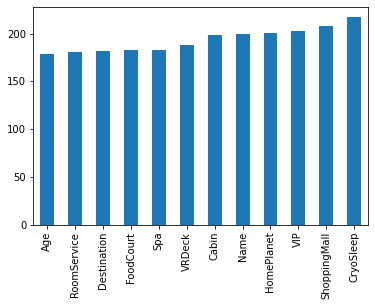

In [3]:
missing = train_data_raw.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

There are missing data in all explanatory variables except for the passenger ID. Let's do a small analysis of the response variable, `Transported`. To start, this variable does not contain missing data.

In [4]:
train_data_raw['Transported'].describe()

count     8693
unique       2
top       True
freq      4378
Name: Transported, dtype: object

So, about half the passengers in the training dataset were transported to another dimension. Let's start by dropping a few useless variables, namely Passenger ID and Name.

In [5]:
train_data = train_data_raw.drop(['PassengerId', 'Name'], axis=1)

We also need to encode some data. Let's look at the distributions of the luxury amenities:

c:\Users\xtomma\Anaconda3\envs\machinelearning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\xtomma\Anaconda3\envs\machinelearning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\xtomma\Anaconda3\envs\machinelearning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

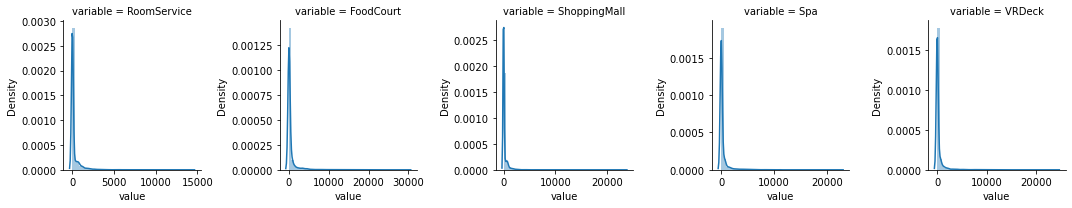

In [6]:
luxury = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
f = pd.melt(train_data, value_vars=luxury)
g = sns.FacetGrid(f, col='variable', col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

From this it seems that most people used very little these possibilities. But is this relevant? 

The numerical variables are: Age, RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck.
The boolean variables are: CryoSleep, VIP, Transported (response)
The categorical variables are: HomePlanet, Cabin, Destination

First we need to deal with Cabin to split it into 3 variables, as it's a composed variable.

### The Cabin variable

We need to encode the Cabin variable in such a way that each of the three represented variables is a different number. First, then, let's separate the variable in three.

In [7]:
train_data['Cabin'].head()

0    B/0/P
1    F/0/S
2    A/0/S
3    A/0/S
4    F/1/S
Name: Cabin, dtype: object

For each entry `entry`, the deck is represented by `entry[0]`, the port by `entry[2]` and the starboard by `entry[4]`. Let's encode these in different variables then.

In [8]:
train_data[['Deck', 'Port', 'Starboard']] = train_data['Cabin'].str.split("/", expand=True)
train_data = train_data.drop(['Cabin'], axis=1)

In [9]:
test_data_raw[['Deck', 'Port', 'Starboard']] = test_data_raw['Cabin'].str.split("/", expand=True)
test_data = test_data_raw.drop(['Cabin'], axis=1)
test_data = test_data.drop(['PassengerId', 'Name'], axis=1)

Next, we encode categorical variables as numbers? I like one-hot encoding, so that's what I'm gonna do:

In [10]:
train_data = pd.get_dummies(train_data, columns=['Destination', 'HomePlanet', 'Deck', 'Port', 'Starboard'])
test_data = pd.get_dummies(test_data, columns=['Destination', 'HomePlanet', 'Deck', 'Port', 'Starboard'])

This leads to a huge dataframe with 1842 columns, which is still manageable. The real issue in all this, is that a) we still not fill NAs, b) we need to turn booleans into 0 and 1, c) tentatively, we could imagine to split the luxury variables into "paid something" and "did not use". It would take away continuous variables and potentially help to better categorize.

### a) fill NAs

In [33]:
print(train_data.columns)

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'Destination_55 Cancri e',
       ...
       'Port_992', 'Port_993', 'Port_994', 'Port_995', 'Port_996', 'Port_997',
       'Port_998', 'Port_999', 'Starboard_P', 'Starboard_S'],
      dtype='object', length=1842)


`'CryoSleep'` and `'VIP'` are booleans, so we fill them with 0s. Because all the `luxury` variables have mostly 0, we do the same. All the categorical variables will also be filled with 0. We will fill only `'Age'` with the mean. 

In [77]:
for column in train_data.columns:
    if column == 'Age':
        train_data[column] = train_data[column].fillna(np.nanmean(train_data['Age']))
    else: 
        train_data[column] = train_data[column].fillna(0)

for column in test_data.columns:
    if column == 'Age':
        test_data[column] = test_data[column].fillna(np.nanmean(test_data['Age']))
    else: 
        test_data[column] = test_data[column].fillna(0)


### b) turn booleans into 0 and 1

In [35]:
train_data[['CryoSleep', 'VIP']]

,CryoSleep,VIP
0,0,0
1,0,0
2,0,1
3,0,0
4,0,0
...,...,...
8688,0,1
8689,1,0
8690,0,0
8691,0,0


In [78]:
train_data['CryoSleep'] = train_data['CryoSleep'].apply(lambda x: int(x))
train_data['VIP'] = train_data['VIP'].apply(lambda x: int(x))

test_data['CryoSleep'] = test_data['CryoSleep'].apply(lambda x: int(x))
test_data['VIP'] = test_data['VIP'].apply(lambda x: int(x))

### c) categorize `luxury` variables

In [79]:
for column in luxury:
    train_data[column] = train_data[column].map(lambda x: 0 if x == 0 else 1)
    test_data[column] = test_data[column].map(lambda x: 0 if x == 0 else 1)

In [38]:
train_data[luxury]

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0,0,0,0,0
1,1,1,1,1,1
2,1,1,0,1,1
3,0,1,1,1,1
4,1,1,1,1,1
...,...,...,...,...,...
8688,0,1,0,1,1
8689,0,0,0,0,0
8690,0,0,1,1,0
8691,0,1,0,1,1


## Train model

In [87]:
train_features = train_data.drop(['Transported'], axis=1)
train_labels = train_data['Transported']

test_features = test_data.drop(['Transported'], axis=1)
test_labels = test_data['Transported']

We apply a normalization layer:

In [44]:
normalizer = layers.Normalization(input_shape=[train_features.shape[1],], axis=-1)
normalizer.adapt(np.array(train_features))

In [67]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(normalizer)
    
    hp_units_1 = hp.Int('units_1', min_value=128, max_value=512, step=32)
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
    model.add(keras.layers.Dense(units=hp_units_1, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(units=hp_units_2, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

    return model


Let's start the tuning.

In [68]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='tuner',
                     project_name='space-titanic',
                     overwrite=True)

In [69]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [70]:
tuner.search(train_features,
             train_labels,
             epochs=50,
             validation_split=0.2,
             callbacks=[stop_early])

Trial 90 Complete [00h 00m 15s]
val_accuracy: 0.6860264539718628

Best val_accuracy So Far: 0.7090281844139099
Total elapsed time: 00h 15m 24s
INFO:tensorflow:Oracle triggered exit


In [72]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the densely-connected layers is {best_hps.get('units_1')} and {best_hps.get('units_2')}, and the optimal learning_rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The optimal number of units in the densely-connected layers is 480 and 64, and the optimal learning_rate for the optimizer is 0.01.



## Train the model

In [74]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_features, train_labels, epochs=50, validation_split=0.2)

Epoch 1/50
218/218 [==============================] - 3s 10ms/step - loss: 0.6926 - accuracy: 0.6099 - val_loss: 0.7631 - val_accuracy: 0.5963
Epoch 2/50
218/218 [==============================] - 2s 10ms/step - loss: 0.6344 - accuracy: 0.6547 - val_loss: 0.6171 - val_accuracy: 0.6481
Epoch 3/50
218/218 [==============================] - 2s 10ms/step - loss: 0.6279 - accuracy: 0.6573 - val_loss: 0.6285 - val_accuracy: 0.6981
Epoch 4/50
218/218 [==============================] - 2s 10ms/step - loss: 0.6107 - accuracy: 0.6671 - val_loss: 0.7081 - val_accuracy: 0.6383
Epoch 5/50
218/218 [==============================] - 2s 10ms/step - loss: 0.6114 - accuracy: 0.6806 - val_loss: 0.6576 - val_accuracy: 0.6814
Epoch 6/50
218/218 [==============================] - 2s 10ms/step - loss: 0.5957 - accuracy: 0.6775 - val_loss: 0.9499 - val_accuracy: 0.6837
Epoch 7/50
218/218 [==============================] - 2s 10ms/step - loss: 0.5884 - accuracy: 0.6777 - val_loss: 0.6541 - val_accuracy: 0.7188

In [75]:
val_accuracy = history.history['val_accuracy']
best_epoch = val_accuracy.index(max(val_accuracy)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 18


In [76]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(train_features, train_labels, epochs=best_epoch, validation_split=0.2)

Epoch 1/18
218/218 [==============================] - 3s 12ms/step - loss: 0.7039 - accuracy: 0.5985 - val_loss: 0.6540 - val_accuracy: 0.5819
Epoch 2/18
218/218 [==============================] - 2s 10ms/step - loss: 0.6455 - accuracy: 0.6427 - val_loss: 0.6526 - val_accuracy: 0.6210
Epoch 3/18
218/218 [==============================] - 2s 10ms/step - loss: 0.6321 - accuracy: 0.6450 - val_loss: 0.6605 - val_accuracy: 0.6895
Epoch 4/18
218/218 [==============================] - 2s 10ms/step - loss: 0.6041 - accuracy: 0.6681 - val_loss: 0.6210 - val_accuracy: 0.6757
Epoch 5/18
218/218 [==============================] - 2s 10ms/step - loss: 0.6122 - accuracy: 0.6641 - val_loss: 0.6549 - val_accuracy: 0.6935
Epoch 6/18
218/218 [==============================] - 2s 10ms/step - loss: 0.5945 - accuracy: 0.6737 - val_loss: 0.6248 - val_accuracy: 0.7108
Epoch 7/18
218/218 [==============================] - 2s 10ms/step - loss: 0.5961 - accuracy: 0.6711 - val_loss: 0.7596 - val_accuracy: 0.7062

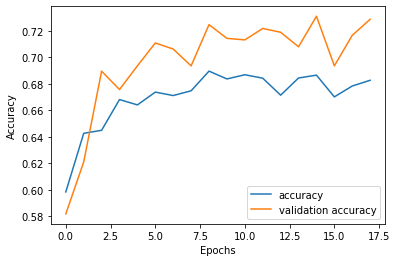

In [85]:
plt.plot(hypermodel.history.history['accuracy'], label='accuracy')
plt.plot(hypermodel.history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

With the model trained, let's evaluate the test data.

In [90]:
predictions = (hypermodel.predict(test_features) > 0.5).astype("int32")
predictions[:,0]

output = pd.DataFrame({'PassengerId': test_data_raw.PassengerId, 'Survived': predictions[:,0]})
output.to_csv('tuner_submission.csv', index=False)

272/272 [==============================] - 1s 4ms/step
